<a href="https://www.kaggle.com/code/bkanupam/vae-and-linear-autoencoders?scriptVersionId=200569079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.multiprocessing as mp
import wandb
import imageio
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [2]:
DATASET_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/lfw-deepfunneled/'
ATTRIBUTES_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/'
class Config:
    RUNTIME = "KAGGLE"
    SUBSET_FRACTION = None
    NUM_EPOCHS = 30
    BATCH_SIZE = 64
    PRECISION = "16-mixed"
    LOG_EVERY_N_STEPS = 10
    INPUT_IMAGE_SIZE = (45, 45)    
    DIM_Z = 100
    NUM_WORKERS = mp.cpu_count()
    EARLY_STOPPING_PATIENCE = 6  # Add this line for early stopping patience
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', Config.DEVICE)

Training on cuda


In [3]:
class SchedulerConfig:
    # for ReduceLROnPlateau (number of epochs with no improvement after which the learning rate will be reduced)
    SCHEDULER_PATIENCE = 5  
    # for ReduceLROnPlateau (factor by which the learning rate will be reduced)
    FACTOR = 0.5 
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts (Number of epochs before the first restart)
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts (Minimum learning rate)
    T_mult = 1 # for CosineAnnealingWarmRestarts (Factor by which Ti(number of epochs between two restarts) increases)
    MAX_LR = 1e-3 # for CosineAnnealing (Initial learning rate)
    STEPS_PER_EPOCH = 13 # for OneCycleLR
    STEP_SIZE = 10 # for StepLR
    GAMMA = 0.5 # for StepLR

In [4]:
class WandbConfig:
    WANDB_KEY = ""
    WANDB_RUN_NAME = "test_run"
    WANDB_PROJECT = "simple_autoencoder"
    USE_WANDB = False    

In [5]:
if Config.RUNTIME == "KAGGLE":
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_KEY = user_secrets.get_secret("wandb")
    DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

if WandbConfig.USE_WANDB:
    # Log in to W&B
    os.environ["WANDB_API_KEY"] = WANDB_KEY
    # Initialize W&B
    wandb.init(project=WandbConfig.WANDB_PROJECT, name=WandbConfig.WANDB_RUN_NAME)

In [6]:
img_df = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    img_df.append({"person":person, "path": path})
 
img_df = pd.DataFrame(img_df)
#too much Bush
img_df = img_df.groupby("person").filter(lambda x: len(x) < 25 )
img_df.head(10)

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


<Axes: xlabel='person'>

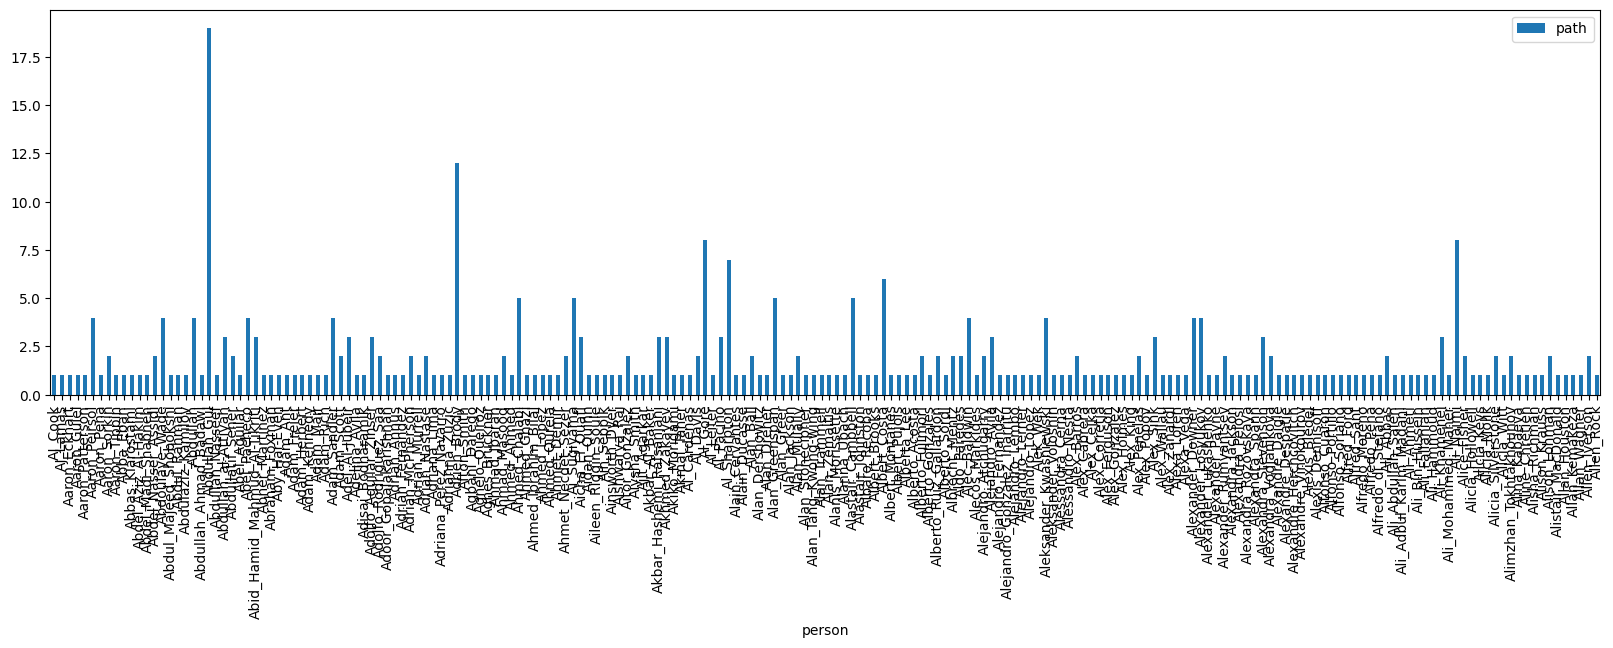

In [7]:
img_df.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

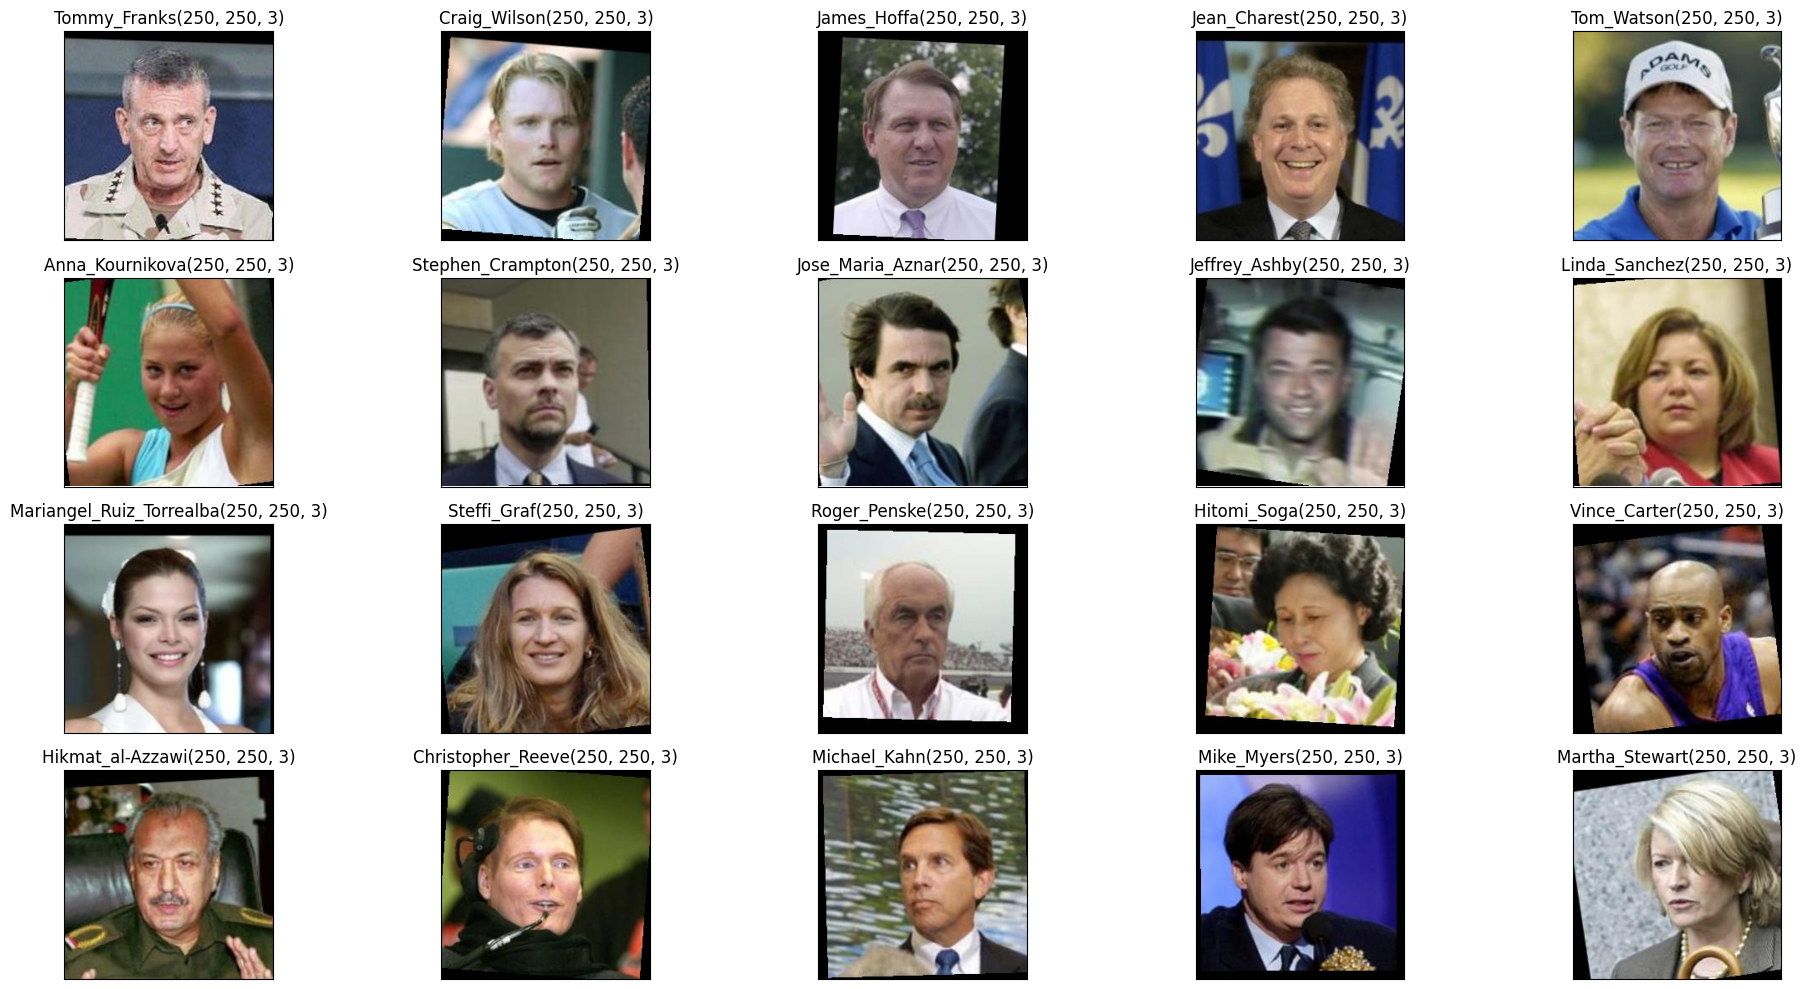

In [8]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(img_df))
    img = plt.imread(img_df.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img_df.person.iloc[idx]+str(img.shape))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [9]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        # image metdadata dataframe containing image path and attributes
        self.df = df        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # idx is index in the image metadata dataframe
        img_path = self.df.loc[idx, "path"]  
        image = Image.open(img_path)               
        width, height = image.size
        # Ensure the crop does not go out of bounds
        left = 80
        right = width - 80
        upper = 80
        lower = height - 80        
        # Check if the crop dimensions are valid
        if right > left and lower > upper:
            image = image.crop((left, upper, right, lower))  # Crop the image
        else:
            raise ValueError("Invalid crop dimensions for the image.")
        if self.transform:
            image = self.transform(image)        
        return image

In [10]:
# Function to display input and output images
def display_images(input_img, output_img, epoch):    
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(input_img)    
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(output_img)    
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()

In [11]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

In [12]:
# split img_df into train and test
if Config.SUBSET_FRACTION is not None:
    img_df = img_df.sample(frac=Config.SUBSET_FRACTION, random_state=42).reset_index(drop=True)

train_df, val_df = train_test_split(img_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [13]:
class AutoencoderDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(Config.INPUT_IMAGE_SIZE),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(df=self.train_df, transform=self.transform)
        self.val_dataset = ImageDataset(df=self.val_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=Config.NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=Config.NUM_WORKERS)

In [14]:
class DisplayImagesCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):                
        print(f"epoch = {trainer.current_epoch}",              
              f"val_loss = {trainer.callback_metrics['val_loss']}, "
              f"val_mse = {trainer.callback_metrics['val_mse']}, "
              f"cur_lr = {trainer.callback_metrics['cur_lr']}, "                        
        )

        # Get a batch of validation images
        val_imgs = next(iter(trainer.datamodule.val_dataloader()))  # Get the first batch
        inputs = val_imgs.to(pl_module.device)  # Move the input images to the appropriate device
        outputs, _, _ = pl_module(inputs)  # Get the model's output for the input images
     
        # Prepare the first input and output image for display
        val_img = inputs[0].permute(1, 2, 0).cpu().detach().numpy()
        output_img = outputs[0].permute(1, 2, 0).cpu().detach().numpy()
        display_images(val_img, output_img, trainer.current_epoch + 1)  # Display the images        

In [15]:
class AutoencoderNetwork(nn.Module):
    def __init__(self, dim_z):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),            
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )

    def encode(self,x):
        x = x.view(-1, 45*45*3)
        return self.encoder(x)
    
    def decode(self,z):
        decoded = self.decoder(z)
        decoded = decoded.view(-1, 3, 45, 45)
        return decoded
    
    def forward(self, x):        
        encoded = self.encode(x) 
        decoded = self.decode(encoded)        
        return decoded

In [16]:
class VAENetwork(nn.Module):
    def __init__(self, dim_z):
        super().__init__()
        self.dim_z = dim_z
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z * 2),  # Output mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 45*45*3)
        )

    def encode(self, x):
        x = x.view(-1, 45*45*3)
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar[:, :self.dim_z], mu_logvar[:, self.dim_z:]  # Split into mean and log variance
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        decoded = self.decoder(z)
        decoded = decoded.view(-1, 3, 45, 45)
        return decoded
    
    def forward(self, x):        
        mu, logvar = self.encode(x) 
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        decoded = self.decode(z)        
        return decoded, mu, logvar  # Return decoded output, mean, and log variance

In [17]:
# Loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [18]:
class VAE(pl.LightningModule):
    def __init__(self, config, scheduler_config):
        super(VAE, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.scheduler_config = scheduler_config
        self.network = VAENetwork(config.DIM_Z)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs = batch
        outputs, mu, logvar = self(inputs)
        loss = vae_loss(outputs, inputs, mu, logvar)
        self.log('train_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch
        outputs, mu, logvar = self(inputs)
        loss = vae_loss(outputs, inputs, mu, logvar)
        mse = vae_loss(outputs, inputs, mu, logvar)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('val_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_mse', mse, on_epoch=True, logger=True, prog_bar=True)
        self.log('cur_lr', current_lr, prog_bar=True, on_epoch=True, logger=True)
        return {'val_loss': loss, 'inputs': inputs, 'outputs': outputs}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.scheduler_config.MAX_LR)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=self.scheduler_config.STEP_SIZE, 
            gamma=self.scheduler_config.GAMMA
        )
        return [optimizer], [scheduler]

In [19]:
class Autoencoder(pl.LightningModule):
    def __init__(self, config, scheduler_config):
        super(Autoencoder, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.scheduler_config = scheduler_config
        self.network = AutoencoderNetwork(config.DIM_Z)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('train_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        mse = F.mse_loss(outputs, inputs)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('val_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_mse', mse, on_epoch=True, logger=True, prog_bar=True)
        self.log('cur_lr', current_lr, prog_bar=True, on_epoch=True, logger=True)
        return {'val_loss': loss, 'inputs': inputs, 'outputs': outputs}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.scheduler_config.MAX_LR)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=self.scheduler_config.STEP_SIZE, 
            gamma=self.scheduler_config.GAMMA
        )
        return [optimizer], [scheduler]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch = 0 val_loss = 269915.78125, val_mse = 269915.78125, cur_lr = 0.0010000000474974513, 


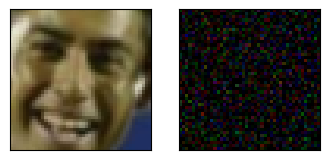

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 0 val_loss = 244057.71875, val_mse = 244057.71875, cur_lr = 0.0009999999310821295, 


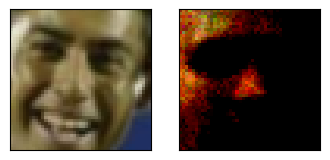

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 1 val_loss = 241773.921875, val_mse = 241773.921875, cur_lr = 0.0009999999310821295, 


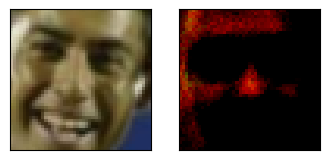

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 2 val_loss = 241104.09375, val_mse = 241104.09375, cur_lr = 0.0009999999310821295, 


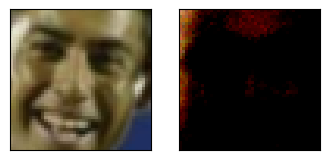

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 3 val_loss = 239825.234375, val_mse = 239825.234375, cur_lr = 0.0009999999310821295, 


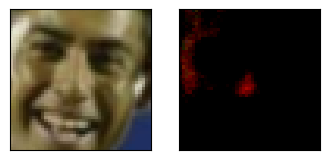

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 4 val_loss = 240345.0625, val_mse = 240345.0625, cur_lr = 0.0009999999310821295, 


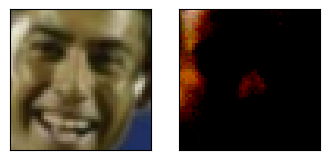

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 5 val_loss = 239571.390625, val_mse = 239571.390625, cur_lr = 0.0009999999310821295, 


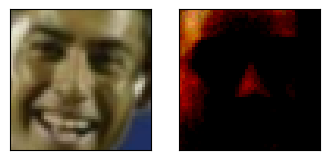

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 6 val_loss = 239206.359375, val_mse = 239206.359375, cur_lr = 0.0009999999310821295, 


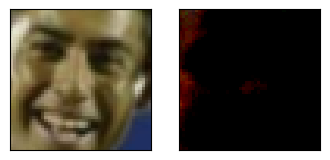

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 7 val_loss = 239081.890625, val_mse = 239081.890625, cur_lr = 0.0009999999310821295, 


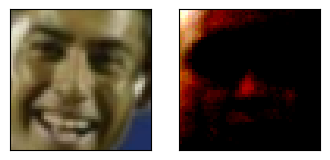

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 8 val_loss = 238858.53125, val_mse = 238858.53125, cur_lr = 0.0009999999310821295, 


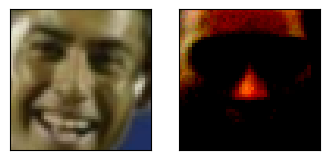

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 9 val_loss = 238820.671875, val_mse = 238820.671875, cur_lr = 0.0004999999655410647, 


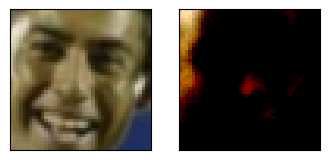

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 10 val_loss = 238407.09375, val_mse = 238407.09375, cur_lr = 0.0004999999655410647, 


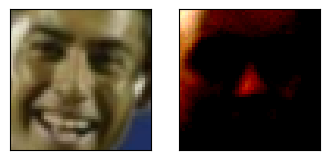

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 11 val_loss = 238294.75, val_mse = 238294.75, cur_lr = 0.0004999999655410647, 


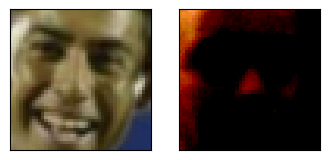

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 12 val_loss = 238410.953125, val_mse = 238410.953125, cur_lr = 0.0004999999655410647, 


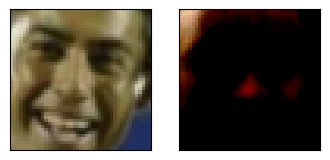

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 13 val_loss = 238195.375, val_mse = 238195.375, cur_lr = 0.0004999999655410647, 


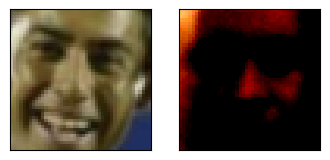

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 14 val_loss = 238367.921875, val_mse = 238367.921875, cur_lr = 0.0004999999655410647, 


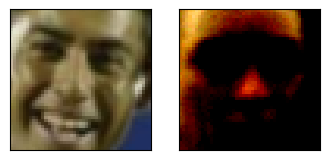

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 15 val_loss = 238368.734375, val_mse = 238368.734375, cur_lr = 0.0004999999655410647, 


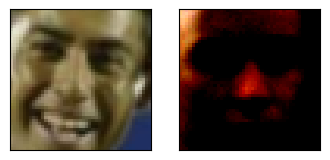

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 16 val_loss = 238052.78125, val_mse = 238052.78125, cur_lr = 0.0004999999655410647, 


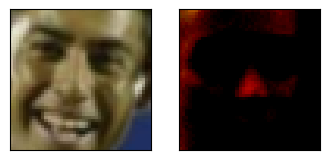

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 17 val_loss = 238194.0625, val_mse = 238194.0625, cur_lr = 0.0004999999655410647, 


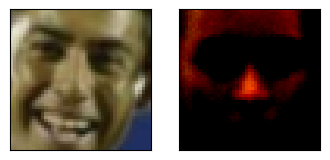

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 18 val_loss = 238227.15625, val_mse = 238227.15625, cur_lr = 0.0004999999655410647, 


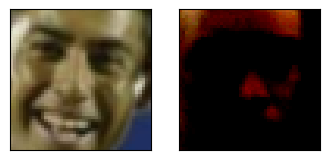

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 19 val_loss = 238200.59375, val_mse = 238200.59375, cur_lr = 0.00024999998277053237, 


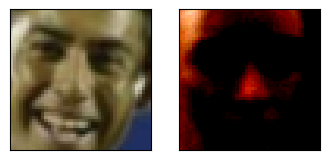

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 20 val_loss = 237807.609375, val_mse = 237807.609375, cur_lr = 0.00024999998277053237, 


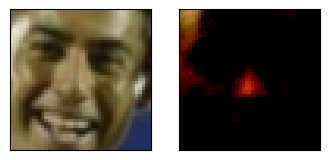

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 21 val_loss = 237918.859375, val_mse = 237918.859375, cur_lr = 0.00024999998277053237, 


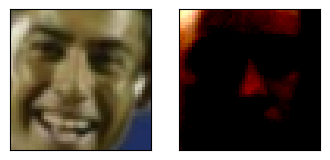

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 22 val_loss = 237827.03125, val_mse = 237827.03125, cur_lr = 0.00024999998277053237, 


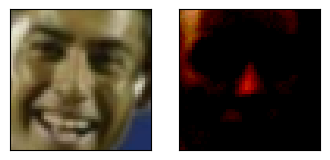

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 23 val_loss = 237846.578125, val_mse = 237846.578125, cur_lr = 0.00024999998277053237, 


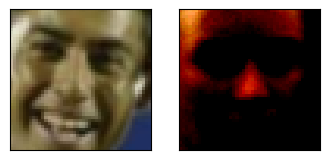

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 24 val_loss = 237775.5625, val_mse = 237775.5625, cur_lr = 0.00024999998277053237, 


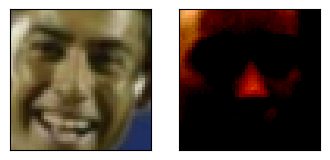

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 25 val_loss = 237850.078125, val_mse = 237850.078125, cur_lr = 0.00024999998277053237, 


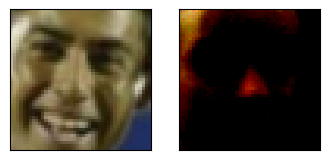

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 26 val_loss = 237791.96875, val_mse = 237791.96875, cur_lr = 0.00024999998277053237, 


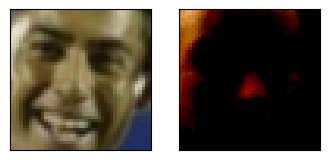

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 27 val_loss = 237905.578125, val_mse = 237905.578125, cur_lr = 0.00024999998277053237, 


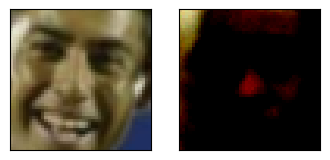

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 28 val_loss = 237863.5625, val_mse = 237863.5625, cur_lr = 0.00024999998277053237, 


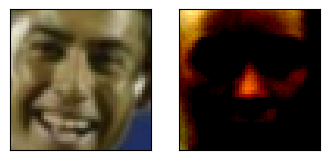

Validation: |          | 0/? [00:00<?, ?it/s]

epoch = 29 val_loss = 237747.9375, val_mse = 237747.9375, cur_lr = 0.00012499999138526618, 


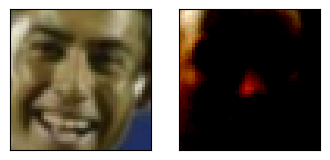

In [20]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
try:    
    data_module = AutoencoderDataModule(train_df, val_df, Config.BATCH_SIZE)    
    model = VAE(Config, SchedulerConfig)
    wandb_logger = None
    if WandbConfig.USE_WANDB:
        wandb_logger = WandbLogger(project=WandbConfig.WANDB_PROJECT, name=WandbConfig.WANDB_RUN_NAME)    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=Config.EARLY_STOPPING_PATIENCE,
        mode='min'
    )    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='autoencoder-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )    
    trainer = pl.Trainer(
        max_epochs=Config.NUM_EPOCHS,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=wandb_logger,
        enable_model_summary=True,
        precision=Config.PRECISION,
        enable_progress_bar=True,
        log_every_n_steps=Config.LOG_EVERY_N_STEPS,
        callbacks=[DisplayImagesCallback(), early_stop_callback, checkpoint_callback]
    )    
    trainer.fit(model, data_module)
except KeyboardInterrupt as e:
    wandb.finish(exit_code=-1, quiet=True)
    print("Marked the wandb run as failed")
finally:    
    wandb.finish()

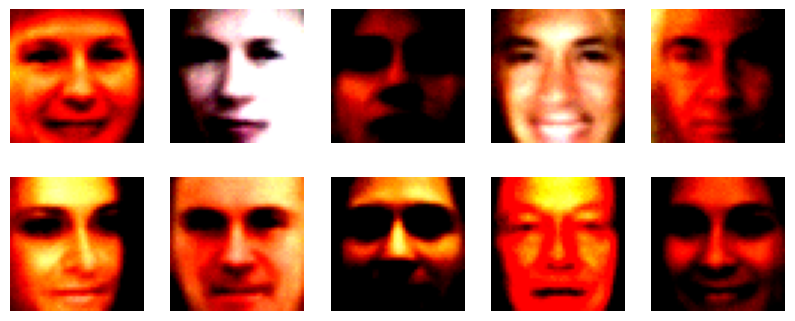

In [21]:
# sample some random latent vectors and decode them
latent_vectors = torch.randn(10, Config.DIM_Z)
decoded_images = model.network.decode(latent_vectors)
# display the original and decoded images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(decoded_images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')
plt.show()